# Neural Network Using Keras on WildFire DataSet (1.8 million)

In [30]:
import pandas as pd
import numpy as np
import sqlite3

conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
df = pd.read_sql("SELECT DISCOVERY_DATE,LONGITUDE,LATITUDE,FIRE_SIZE,FIRE_YEAR, STAT_CAUSE_DESCR,STATE from Fires",con=conn)
print("DataSet Size = ",len(df))
df.head(4)


DataSet Size =  1880465


,DISCOVERY_DATE,LONGITUDE,LATITUDE,FIRE_SIZE,FIRE_YEAR,STAT_CAUSE_DESCR,STATE
0,2453403.5,-121.005833,40.036944,0.10,2005,Miscellaneous,CA
1,2453137.5,-120.404444,38.933056,0.25,2004,Lightning,CA
2,2453156.5,-120.735556,38.984167,0.10,2004,Debris Burning,CA
3,2453184.5,-119.913333,38.559167,0.10,2004,Lightning,CA


## Preprocessing for Date

In [31]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.weekday
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df['DISCOVERY_DATE']=df.DISCOVERY_DATE.apply(lambda x: x.strftime('%Y%m%d')).astype(int)
df.head(5)

,DISCOVERY_DATE,LONGITUDE,LATITUDE,FIRE_SIZE,FIRE_YEAR,STAT_CAUSE_DESCR,STATE,MONTH,DAY_OF_WEEK
0,20050202,-121.005833,40.036944,0.10,2005,Miscellaneous,CA,2,2
1,20040512,-120.404444,38.933056,0.25,2004,Lightning,CA,5,2
2,20040531,-120.735556,38.984167,0.10,2004,Debris Burning,CA,5,0
3,20040628,-119.913333,38.559167,0.10,2004,Lightning,CA,6,0
4,20040628,-119.933056,38.559167,0.10,2004,Lightning,CA,6,0


In [32]:
# Removing records that have no proper cause labels
df = df[df['STAT_CAUSE_DESCR'] != 'Missing/Undefined']
df = df[df['STAT_CAUSE_DESCR'] != 'Miscellaneous']
print('Dataset Size', len(df))

Dataset Size 1389937


## Grouping Target into multiple classes (Natural,Accidental,Intentional)

In [33]:
df['STAT_CAUSE_LABEL'] = df['STAT_CAUSE_DESCR'].apply(lambda x: 1 if x in ['Lightning'] else
                                                     2 if x in ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
                                                         else 3)
df = df.drop('STAT_CAUSE_DESCR',axis=1)
print(df.head())

   DISCOVERY_DATE   LONGITUDE   LATITUDE  FIRE_SIZE  FIRE_YEAR STATE  MONTH  \
1        20040512 -120.404444  38.933056       0.25       2004    CA      5   
2        20040531 -120.735556  38.984167       0.10       2004    CA      5   
3        20040628 -119.913333  38.559167       0.10       2004    CA      6   
4        20040628 -119.933056  38.559167       0.10       2004    CA      6   
5        20040630 -120.103611  38.635278       0.10       2004    CA      6   

   DAY_OF_WEEK  STAT_CAUSE_LABEL  
1            2                 1  
2            0                 2  
3            0                 1  
4            0                 1  
5            2                 1  


In [34]:
# Encoding State to labels
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["STATE"] = lb_make.fit_transform(df["STATE"])
df.head(2)

,DISCOVERY_DATE,LONGITUDE,LATITUDE,FIRE_SIZE,FIRE_YEAR,STATE,MONTH,DAY_OF_WEEK,STAT_CAUSE_LABEL
1,20040512,-120.404444,38.933056,0.25,2004,4,5,2,1
2,20040531,-120.735556,38.984167,0.10,2004,4,5,0,2


In [35]:
X = df.drop(columns='STAT_CAUSE_LABEL')
y = df['STAT_CAUSE_LABEL']

## Normalizing Data

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled,columns=X.columns.tolist())

In [37]:
# dont do encoding if using sparse categorial corss entropy
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y[:, np.newaxis]).toarray()

In [69]:
from sklearn.model_selection import train_test_split
X_inter,X_test,y_inter,y_test = train_test_split(X,y,shuffle=True,random_state=15,test_size=0.2)
X_train,X_valid,y_train,y_valid = train_test_split(X_inter,y_inter, shuffle=False,random_state=2018,test_size=0.25)
del X_inter, y_inter
print("train: {}% | validation: {}% | test {}%".format(round(len(y_train)/len(y),2),
                                                       round(len(y_valid)/len(y),2),
                                                       round(len(y_test)/len(y),2)))

train: 0.6% | validation: 0.2% | test 0.2%


In [70]:
import ssl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
from keras.models import Sequential
from keras.layers import Dense
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [71]:
X_train = X_train.iloc[:].values # converting into numpy array
X_test = X_test.iloc[:].values
X_valid = X_valid.iloc[:].values

In [72]:
features = len(X.columns)
classes = 3
def create_models(input_dim, output_dim, nodes, n=1, name='wildfiremodel'):
    def get_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim))

        # Compile model
        model.compile( loss=keras.losses.CategoricalCrossentropy(from_logits=True,reduction='none'),
            optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
        return model
    return get_model


In [79]:
models = [create_models(features, classes, 10, i, 'wildfireModel_{}'.format(i)) 
          for i in range(1, 4)]

for get_model in models:
    get_model().summary()

Model: "wildfireModel_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_182 (Dense)            (None, 3)                 33        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________
Model: "wildfireModel_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_184 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_185 (Dense)            (None, 3)                 33        
Total params: 233
Trainable 

In [77]:
models = [create_models(features,classes,10,3)]
for get_model in models:
    get_model().summary()

Model: "wildfiremodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_174 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_175 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_176 (Dense)            (None, 3)                 33        
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


In [80]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for get_model in models:
    model = get_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, y_train,
                                 batch_size=1000,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_valid,y_valid),
                                 callbacks=[cb])
    score = model.evaluate(X_test, y_test, verbose=2)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: wildfireModel_1
8688/8688 - 7s - loss: 0.6952 - accuracy: 0.6987
Test loss: 0.6952000856399536
Test accuracy: 0.6986596584320068
Model name: wildfireModel_2
8688/8688 - 7s - loss: 0.6640 - accuracy: 0.7095
Test loss: 0.6640365123748779
Test accuracy: 0.7095306515693665
Model name: wildfireModel_3
8688/8688 - 11s - loss: 0.6533 - accuracy: 0.7151
Test loss: 0.6533129811286926
Test accuracy: 0.7150704264640808


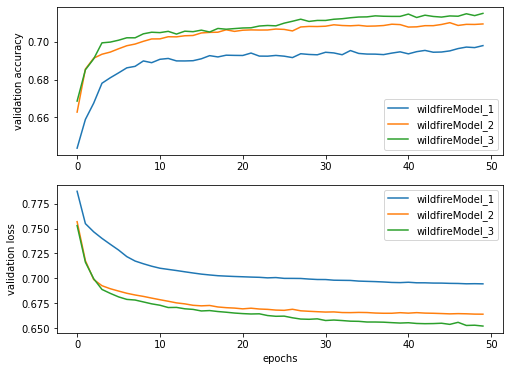

In [81]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();